<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Очистка-текста" data-toc-modified-id="Очистка-текста-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Очистка текста</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Выделение-выборок-и-целевого-признака" data-toc-modified-id="Выделение-выборок-и-целевого-признака-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Выделение выборок и целевого признака</a></span></li><li><span><a href="#Обработка-дисбаланса" data-toc-modified-id="Обработка-дисбаланса-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Обработка дисбаланса</a></span></li><li><span><a href="#Стоп-слова-и-векторы" data-toc-modified-id="Стоп-слова-и-векторы-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Стоп-слова и векторы</a></span></li><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#Проверка-на-тестовой-выборке" data-toc-modified-id="Проверка-на-тестовой-выборке-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Проверка на тестовой выборке</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Значение метрики качества F1 должно быть не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
!pip install re
!pip install spacy
!pip install nltk
!pip install catboost

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [2]:
# импорт библиотек
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import catboost as cb
from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score

## Подготовка данных

Загрузим предоставленный датасет.

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 81.1 MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### Очистка текста

Напишем метод для очистки текста от знаков.

In [4]:
def clear_text(text):
  clear = re.sub(r"(?:\n|\r)", " ", text)
  clear = re.sub(r'[^a-zA-Z ]', ' ', clear)
  clear = clear.lower()
  return " ".join(clear.split())

In [5]:
data['text'] = data['text'].apply(clear_text)
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


Проверим, не появилось ли у нас пустых строк после удаления символов, и удалим их.

In [6]:
data.loc[data['text'] == '', 'text'].count()

11

In [7]:
data = data.loc[data['text'] != '']
data.loc[data['text'] == '', 'text'].count()

0

### Лемматизация

Лемматизируем тексты используя библиотеку spacy.

In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
def lemma_by_spacy_clear(text):
    lemmed = nlp(text)
    lemmed = " ".join([token.lemma_ for token in lemmed])
    return " ".join(lemmed.split())

In [10]:
%%time

data['text'] = data['text'].apply(lemma_by_spacy_clear)
print(data.head())

                                                text  toxic
0  explanation why the edit make under my usernam...      0
1  d aww he match this background colour I m seem...      0
2  hey man I m really not try to edit war it s ju...      0
3  more I can t make any real suggestion on impro...      0
4  you sir be my hero any chance you remember wha...      0
CPU times: user 44min 48s, sys: 18.9 s, total: 45min 7s
Wall time: 45min 41s


### Выделение выборок и целевого признака

Разбиваем датасет на выборки в соотношении 8:1:1.

In [11]:
data_train, data_valid_test = train_test_split(data, test_size = 0.1, random_state = 12345)
data_valid, data_test = train_test_split(data_valid_test, test_size = 0.5, random_state = 12345)
print(data_train.shape, data_valid.shape, data_test.shape)

(143352, 2) (7964, 2) (7965, 2)


В валидационной и тестовой выборках отделяем целевой признак. В тренировочной мы сделаем это после обработки дисбаланса.

In [12]:
features_valid = data_valid['text']
target_valid = data_valid['toxic']

features_test = data_test['text']
target_test = data_test['toxic']

print(features_valid.shape, features_test.shape)
print(target_valid.shape, target_test.shape)

(7964,) (7965,)
(7964,) (7965,)


### Обработка дисбаланса

Посмотрим распределение категорий целевого признака в тренировочной выборке.

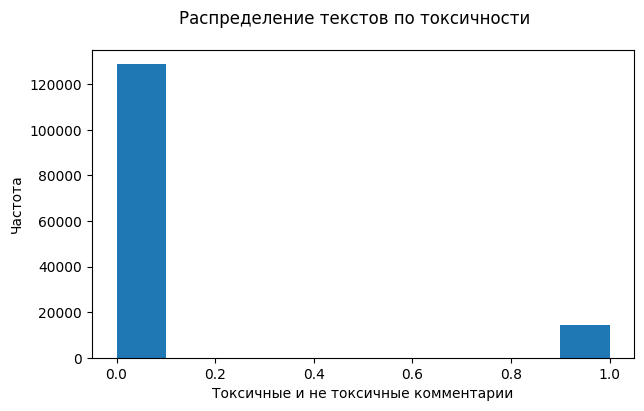

In [13]:
fig, axes = plt.subplots(1,figsize=(7,4))
axes.hist(data_train['toxic'])
fig.suptitle('Распределение текстов по токсичности')
axes.set_ylabel('Частота')
axes.set_xlabel('Токсичные и не токсичные комментарии')
plt.show()

Можно наблюдать большой дисбаланс классов. Избавимся от него, применив апсэмплинг.

Колличество комментариев категории 0 = 128777 , категории 1 = 14575 , разница 114202 , повторений 7


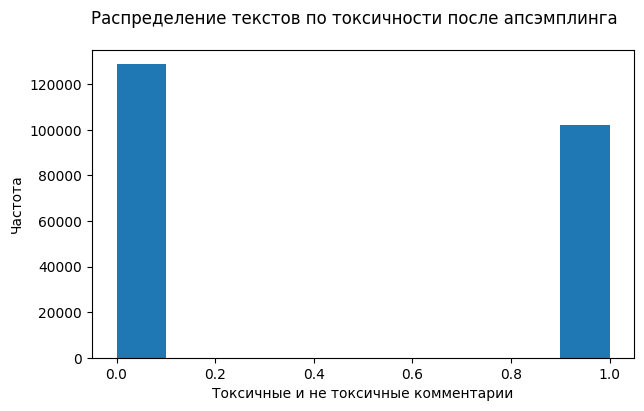

CPU times: user 358 ms, sys: 121 ms, total: 479 ms
Wall time: 377 ms


In [14]:
%%time

len_0 = data_train.loc[data_train['toxic'] == 0].shape[0]
len_1 = data_train.loc[data_train['toxic'] == 1].shape[0]
dif = len_0 - len_1
repeat = int(dif / len_1)
print('Колличество комментариев категории 0 =', len_0, ', категории 1 =', len_1, ', разница', dif, ', повторений', repeat)

data_0 = data_train.loc[data_train['toxic'] == 0]
data_1 = data_train.loc[data_train['toxic'] == 1]
data_train = pd.concat([data_0] + [data_1] * repeat)

data_train = shuffle(data_train, random_state=12345)
features_train = data_train['text']
target_train = data_train['toxic']
fig, axes = plt.subplots(1,figsize=(7,4))
axes.hist(target_train)
fig.suptitle('Распределение текстов по токсичности после апсэмплинга')
axes.set_ylabel('Частота')
axes.set_xlabel('Токсичные и не токсичные комментарии')
plt.show()

### Стоп-слова и векторы

Загружаем стоп-слова и инициализируем счётчик.

In [15]:
nltk.download('stopwords')
sw = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
counter = TfidfVectorizer(stop_words=list(sw))

Переводим тексты в векторный вид.

In [17]:
tfidf_train = counter.fit_transform(features_train)
tfidf_valid = counter.transform(features_valid)
tfidf_test = counter.transform(features_test)

### Промежуточный вывод

В разделе "Подготовка данных" мы:

- Загрузили данные
- Провели очистку текста от знаков, привели его к нижнему регистру
- Выделили обучающую и тестовую выборки
- Отделили целевой признак от нецелевого
- Лемматизировали тексты
- Загрузили стоп-слова и простроили векторы из текстов

## Обучение

### Логистическая регрессия

In [18]:
%%time

model_regression = LogisticRegression(random_state=12345)
model_regression.fit(tfidf_train, target_train)
pred = model_regression.predict(tfidf_valid)
f1_regression = f1_score(target_valid, pred)
print('F1-метрика для логистической регрессии равна', f1_regression)

F1-метрика для логистической регрессии равна 0.7761194029850745
CPU times: user 13.7 s, sys: 13.2 s, total: 26.8 s
Wall time: 15.4 s


### Решающее дерево

In [19]:
%%time

model_tree = None
best_depth = 0
f1_tree = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(tfidf_train, target_train)
    pred = model.predict(tfidf_valid)
    f1 = f1_score(target_valid, pred)
    if f1 > f1_tree:
        f1_tree = f1
        best_depth = depth
        model_tree = model

print('F1-метрика для решающего дерева равна', f1_tree, 'при максимальной глубине', best_depth)

F1-метрика для решающего дерева равна 0.5990099009900991 при максимальной глубине 9
CPU times: user 1min 1s, sys: 356 ms, total: 1min 1s
Wall time: 1min 1s


### Случайный лес

In [20]:
%%time

model_forest = None
best_depth = 0
best_est = 0
f1_forest = 0

for est in range(10, 51, 20):
    for depth in range(1, 6):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(tfidf_train, target_train)
        pred = model.predict(tfidf_valid)
        f1 = f1_score(target_valid, pred)
        if f1 > f1_forest:
            f1_forest = f1
            best_depth = depth
            best_est = est
            model_forest = model

print('F1-метрика для случайного леса равна', f1_forest, 'при максимальной глубине', best_depth, 'и колличестве деревьев', best_est)

F1-метрика для случайного леса равна 0.2138084632516704 при максимальной глубине 5 и колличестве деревьев 10
CPU times: user 21.1 s, sys: 585 ms, total: 21.6 s
Wall time: 21.8 s


### Градиентный бустинг

Для бустинга возьмём библиотеку CatBoost.

In [21]:
%%time

model_cb = None
best_depth = 0
best_est = 0
f1_cb = 0

for est in range(10, 51, 20):
    for depth in range(1, 6):
        model = cb.CatBoostClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(tfidf_train, target_train)
        pred = model.predict(tfidf_valid)
        f1 = f1_score(target_valid, pred)
        if f1 > f1_cb:
            f1_cb = f1
            best_depth = depth
            best_est = est
            model_cb = model

print('F1-метрика для градиентного бустинга CatBoost равна', f1_cb, 'при максимальной глубине', best_depth, 'и колличестве деревьев', best_est)

Learning rate set to 0.5
0:	learn: 0.6331528	total: 862ms	remaining: 7.76s
1:	learn: 0.6132504	total: 1.58s	remaining: 6.31s
2:	learn: 0.5888015	total: 2.56s	remaining: 5.99s
3:	learn: 0.5736568	total: 3.79s	remaining: 5.68s
4:	learn: 0.5624165	total: 4.91s	remaining: 4.91s
5:	learn: 0.5503989	total: 5.67s	remaining: 3.78s
6:	learn: 0.5396835	total: 6.38s	remaining: 2.73s
7:	learn: 0.5251956	total: 7.09s	remaining: 1.77s
8:	learn: 0.5137247	total: 7.82s	remaining: 869ms
9:	learn: 0.5072206	total: 8.52s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6098704	total: 956ms	remaining: 8.61s
1:	learn: 0.5756419	total: 1.89s	remaining: 7.56s
2:	learn: 0.5510892	total: 2.78s	remaining: 6.49s
3:	learn: 0.5254592	total: 3.73s	remaining: 5.59s
4:	learn: 0.5072712	total: 4.64s	remaining: 4.64s
5:	learn: 0.4967864	total: 6.05s	remaining: 4.03s
6:	learn: 0.4851350	total: 7.58s	remaining: 3.25s
7:	learn: 0.4735494	total: 8.61s	remaining: 2.15s
8:	learn: 0.4670875	total: 9.54s	remaining: 1.06s
9:

Построим столбчатую диаграмму, а накоторой для сравнения изобразим F1-метрики всех четырёх моделей.

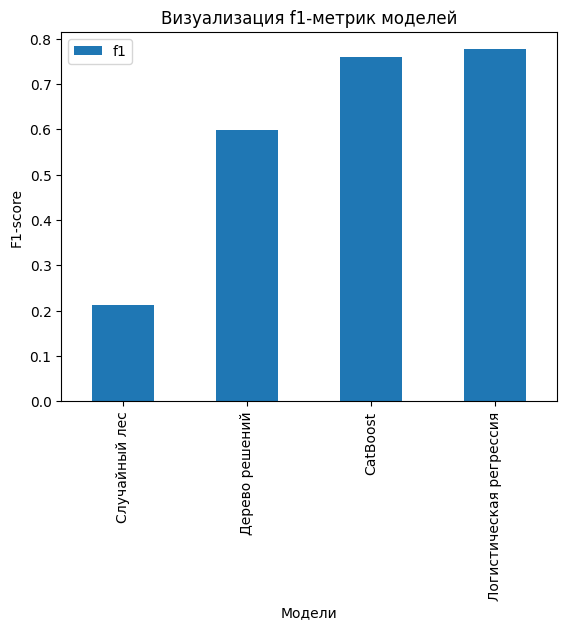

In [22]:
scores = [f1_regression, f1_tree, f1_forest, f1_cb]
ids = ['Логистическая регрессия','Дерево решений', 'Случайный лес', 'CatBoost']
top_rmse = pd.DataFrame(data=scores, index=ids, columns=['f1'])
top_rmse.sort_values(by='f1').plot.bar(title='Визуализация f1-метрик моделей', xlabel='Модели', ylabel='F1-score');

Как видно по графику выше, самой высокой метрикой F1 обладает логистическая регрессия. С небольшим от неё отставанием находится градиентный бустинг из библиотеки CatBoost. Дерево решений и случайный лес показали результат ниже требуемого.

Таким образом, самый высокий результат (0,77) у логистической регрессии.

### Проверка на тестовой выборке

Лучшую модель проверим на тестовой выборке.

In [23]:
pred_test = model_regression.predict(tfidf_test)
f1_test = f1_score(pred_test, target_test)
print('F1-метрика на тестовой выборке =', f1_test)

F1-метрика на тестовой выборке = 0.7664804469273743


## Выводы

В данном проекте по машинному обучению задачей было обучить модель классифицировать комментарии, как позитивные и негативные. Для этого были произведены следующие работы:

- Загружены комментарии, промаркированные по целевому признаку;
- Обработан дисбаланс классов посредством даунсэмплинга;
- Тексты комментариев очищены от знаков, буквы приведены к нижнему регистру;
- Выделены обучающая и тестовая выборки, отделён целевой признак;
- Лемматизированы тексты;
- Загружен список стоп-слов для английского языка, тексты приведены к векторному виду;
- Обучены четыре модели: логистическая регрессия, решающее дерево, случайный лес и градиентный бустинг на деревьях;
- Модели сравнены по F1-метрике, выбран лучший результат.

По итогу, лучшую F1-метрику показала логистическая регрессия, её результат был на валидационной выборке 0,77, на тестовой 0,76, при минимальном требовании 0,75.